In [ ]:
# --- Setup base dir & env, then import deps (condensed) ---

# Stdlib
import os, sys
from pathlib import Path

def get_basedir(up: int = 2) -> Path:
    """Return dir `up` levels above running .py/.ipynb."""
    try:
        p = Path(__file__).resolve()        # .py
    except NameError:
        try:
            import ipynbname                # notebook
            p = Path(ipynbname.path()).resolve()
        except Exception:
            p = (Path.cwd() / "_dummy").resolve()    # fallback
    for _ in range(up): p = p.parent
    return p

# only initialize BASE_DIR once
BASE_DIR = globals().get("BASE_DIR")
if not isinstance(BASE_DIR, Path) or not BASE_DIR.exists():
    BASE_DIR = get_basedir()
    
sys.path[:0] = [
    str(BASE_DIR),
    str(BASE_DIR / "packages"),
    str(BASE_DIR / "packages" / "DiffBIR"),
    str(BASE_DIR / "packages" / "MST" / "simulation" / "train_code"),
]
os.chdir(BASE_DIR)
print(f"Set BASE = {BASE_DIR}")
os.environ.update({"CUDA_DEVICE_ORDER": "PCI_BUS_ID", "CUDA_VISIBLE_DEVICES": "1"})

# Third-party
import numpy as np, torch, scipy.io as scio, pytorch_lightning as pl
from argparse import ArgumentParser, Namespace 
from typing import Optional, Tuple, Set, List, Dict 
from torch import nn
from torch.nn import functional as F
from PIL import Image
from omegaconf import OmegaConf
from skimage.metrics import structural_similarity as ssim
from accelerate.utils import set_seed
from hyperopt import hp, fmin, tpe, Trials
import matplotlib.pyplot as plt

# Project
from packages.DiffBIR.utils.common import (
    instantiate_from_config, load_file_from_url, count_vram_usage,
    wavelet_decomposition, wavelet_reconstruction, wavelet_decomposition_msi,
)
from packages.DiffBIR.utils.inference import InferenceLoop
from packages.DiffBIR.utils.helpers import MSI_Pipeline
from packages.DiffBIR.utils.cond_fn import MeasMSEGuidance, Guidance
from packages.DiffBIR.model.gaussian_diffusion import Diffusion
from packages.DiffBIR.model.cldm import ControlLDM
from packages.MST.simulation.train_code.utils import *
from packages.MST.simulation.train_code.architecture import *


In [ ]:
MODELS = {
    # stage_1 model weights
    "bsrnet": "https://github.com/cszn/KAIR/releases/download/v1.0/BSRNet.pth",
    # the following checkpoint is up-to-date, but we use the old version in our paper
    # "swinir_face": "https://github.com/zsyOAOA/DifFace/releases/download/V1.0/General_Face_ffhq512.pth",
    "swinir_face": "https://huggingface.co/lxq007/DiffBIR/resolve/main/face_swinir_v1.ckpt",
    "scunet_psnr": "https://github.com/cszn/KAIR/releases/download/v1.0/scunet_color_real_psnr.pth",
    "swinir_general": "https://huggingface.co/lxq007/DiffBIR/resolve/main/general_swinir_v1.ckpt",
    # stage_2 model weights
    "sd_v21": "https://huggingface.co/stabilityai/stable-diffusion-2-1-base/resolve/main/v2-1_512-ema-pruned.ckpt",
    "v1_face": "https://huggingface.co/lxq007/DiffBIR-v2/resolve/main/v1_face.pth",
    "v1_general": "https://huggingface.co/lxq007/DiffBIR-v2/resolve/main/v1_general.pth",
    "v2": "https://huggingface.co/lxq007/DiffBIR-v2/resolve/main/v2.pth"
}


def load_model_from_url(url: str) -> Dict[str, torch.Tensor]:
    sd_path = load_file_from_url(url, model_dir=str(BASE_DIR)+"/packages/DiffBIR/weights")
    sd = torch.load(sd_path, map_location="cpu", weights_only=False)
    if "state_dict" in sd:
        sd = sd["state_dict"]
    if list(sd.keys())[0].startswith("module"):
        sd = {k[len("module."):]: v for k, v in sd.items()}
    return sd


class InferenceLoop_NoPre:

    def __init__(self, args: Namespace) -> "InferenceLoop":
        self.args = args
        self.loop_ctx = {}
        self.pipeline: MSI_Pipeline = None
        self.init_stage2_model()

    @count_vram_usage
    def init_stage2_model(self) -> None:
        # load uent, vae, clip
        self.cldm: ControlLDM = instantiate_from_config(OmegaConf.load(str(BASE_DIR)+"/packages/DiffBIR/configs/inference/cldm.yaml"))
        sd = load_model_from_url(MODELS["sd_v21"])
        unused = self.cldm.load_pretrained_sd(sd)
        print(f"strictly load pretrained sd_v2.1, unused weights: {unused}")
        # load controlnet
        self.cldm.load_controlnet_from_ckpt(torch.load(self.args.ckpt, map_location="cpu"))
        print(f"strictly load controlnet weight {self.args.ckpt}")
        if self.args.vae != None:
            self.cldm.load_vae_from_ckpt(torch.load(self.args.vae, map_location="cpu"))
            print(f"strictly load vae weight {self.args.vae}")
        self.cldm.eval().cuda()
        # load diffusion
        self.diffusion: Diffusion = instantiate_from_config(OmegaConf.load(str(BASE_DIR)+"/packages/DiffBIR/configs/inference/diffusion.yaml"))
        self.diffusion.cuda()

    @torch.no_grad()
    def run(self, images: torch.tensor) -> torch.tensor:
        # We don't support batch processing since input images may have different size

        return self.pipeline.run_stage2(
            images, self.args.steps, 1.0, self.args.tiled,
            self.args.tile_size, self.args.tile_stride,
            self.args.pos_prompt, self.args.neg_prompt, self.args.cfg_scale,
            self.args.better_start
        )


@torch.no_grad()
def preprocess_data(input_meas: torch.tensor, input_mask: torch.tensor, PSRSCI_Pipeline: InferenceLoop_NoPre) -> Tuple[torch.tensor, torch.tensor]:
    """
    Preprocess input data by applying necessary transformations and normalization.

    Args:
        input_meas (torch.tensor): Input measurement data.
        input_mask (torch.tensor): Input mask data.
        model (ControlLDM): Model instance.

    Returns:
        Tuple[torch.tensor, torch.tensor]: Tuple containing preprocessed RGB images and normalization coefficients.
    """

    n_samples = input_meas.shape[0]

    with torch.no_grad():
        MSI_IMAGE = PSRSCI_Pipeline.MSI_model(input_meas, input_mask)
        inputs_msi_hf, inputs_msi_lf = wavelet_decomposition_msi(MSI_IMAGE, 3)

        MSI_images_encoded = PSRSCI_Pipeline.encoder(inputs_msi_hf)

        RANGE_MAX = 0.85
        RANGE_MIN = 0.15

        range_channel = torch.tensor([MSI_images_encoded[i].max() - MSI_images_encoded[i].min() for i in range(n_samples)]).cuda()
        max_val_channel = torch.tensor([MSI_images_encoded[i].max() + range_channel[i] / (RANGE_MAX - RANGE_MIN)*(1-RANGE_MAX) for i in range(n_samples)]).cuda().view(n_samples, 1, 1, 1)
        min_val_channel = torch.tensor([MSI_images_encoded[i].min() - range_channel[i] / (RANGE_MAX - RANGE_MIN)*(RANGE_MIN) for i in range(n_samples)]).cuda().view(n_samples, 1, 1, 1)

        normalized_images = (MSI_images_encoded - min_val_channel) / (max_val_channel - min_val_channel)

        return normalized_images, max_val_channel, min_val_channel, inputs_msi_lf

@torch.no_grad()
def process_diffusion(
    PSRSCI_Pipeline: InferenceLoop_NoPre,
    normalized_images: torch.tensor,
    max_val_channel: torch.tensor,
    min_val_channel: torch.tensor,
    inputs_msi_lf: torch.tensor,
    steps: int,
    upscale: int,
    cfg_scale: float,
    cond_fn: Optional[MeasMSEGuidance],
    tiled: bool,
    tile_size: int,
    tile_stride: int,
    better_start: bool = False,
    pos_prompt: str = "",
    neg_prompt: str = "low quality, blurry, low-resolution, noisy, unsharp, weird textures",
) -> Tuple[torch.tensor, torch.tensor]:
    """
    Apply Diffusion model on preprocessed data to generate restoration results.

    Args:
        model (ControlLDM): Model.
        normalized_images (torch.tensor): Preprocessed normalized images.
        max_val_channel (torch.tensor): Maximum values for each channel.
        min_val_channel (torch.tensor): Minimum values for each channel.
        steps (int): Sampling steps.
        strength (float): Control strength.
        color_fix_type (str): Type of color correction for samples.
        cond_fn (Guidance | None): Guidance function.
        tiled (bool): If True, a patch-based sampling strategy will be used.
        tile_size (int): Size of patch.
        tile_stride (int): Stride of sliding patch.

    Returns:
        Tuple[torch.tensor, torch.tensor]: Tuple containing restored images and diffusion outputs.
    """

    if upscale > 1.0:
        normalized_images_up = F.interpolate(normalized_images, size=(normalized_images.shape[-2] * upscale, normalized_images.shape[-1] * upscale), mode="bicubic", antialias=True)
    else:
        normalized_images_up = normalized_images

    PSRSCI_Pipeline.pipeline = MSI_Pipeline(PSRSCI_Pipeline.cldm, PSRSCI_Pipeline.diffusion, cond_fn, PSRSCI_Pipeline.args.device)

    diffusion_output = PSRSCI_Pipeline.pipeline.run_stage2(
        clean=normalized_images_up, steps=steps, strength=1.0, upscale=upscale, tiled=tiled, tile_size=tile_size, tile_stride=tile_stride,
        pos_prompt=pos_prompt, neg_prompt=neg_prompt, cfg_scale=cfg_scale, better_start=better_start
    )

    if upscale > 1.0:
        diffusion_output = F.interpolate(
            diffusion_output,
            size=(normalized_images.shape[-2], normalized_images.shape[-1]),
            mode="bicubic", antialias=True
        )

    diffusion_outputs = diffusion_output.contiguous().clamp(0, 1)

    restored_images = PSRSCI_Pipeline.decoder(diffusion_outputs * (max_val_channel - min_val_channel) + min_val_channel) + inputs_msi_lf

    return restored_images, diffusion_outputs

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=2):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.max_pool = nn.AdaptiveMaxPool2d((2, 2))

        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False)
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, 2, bias=False)

        self.SiLU = nn.SiLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.SiLU(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.SiLU(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


class DoubleConvWoBN(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU(inplace=True),
        )
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.double_conv(x) + self.res_conv(x)


class ChannelEncoder(nn.Module):
    def __init__(self):
        super(ChannelEncoder, self).__init__()
        self.conv1 = DoubleConvWoBN(in_channels=28, out_channels=21)
        self.conv2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear"),
            DoubleConvWoBN(in_channels=21, out_channels=9),
        )
        self.conv3 = DoubleConvWoBN(in_channels=9, out_channels=3)
        self.conv_out = DoubleConvWoBN(in_channels=3, out_channels=3)
        self.conv_res = nn.Sequential(
            DoubleConvWoBN(in_channels=28, out_channels=3),
            nn.Upsample(scale_factor=2, mode="bilinear"),
        )

        self.ca1 = ChannelAttention(28, 2)
        self.ca2 = ChannelAttention(21, 2)
        self.ca3 = ChannelAttention(9, 2)
        self.ca_res = ChannelAttention(28, 2)

    def forward(self, x):

        res = self.conv_res(x * self.ca_res(x))

        x = x * self.ca1(x)
        x = self.conv1(x)

        x = x * self.ca2(x)
        x = self.conv2(x)

        x = x * self.ca3(x)
        x = self.conv3(x)

        x = self.conv_out(x + res)
        return x


class ChannelDecoder(nn.Module):
    def __init__(self):
        super(ChannelDecoder, self).__init__()
        self.conv1 = DoubleConvWoBN(in_channels=3, out_channels=9)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=9, out_channels=21, kernel_size=2, stride=2),
            nn.SiLU(inplace=True),
            DoubleConvWoBN(in_channels=21, out_channels=21),
        )
        self.conv3 = DoubleConvWoBN(in_channels=21, out_channels=28)
        self.conv_out = DoubleConvWoBN(in_channels=28, out_channels=28)
        self.conv_res = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=2, stride=2),
            DoubleConvWoBN(in_channels=3, out_channels=28),
        )

        self.ca3 = ChannelAttention(28, 2)
        self.ca2 = ChannelAttention(21, 2)
        self.ca1 = ChannelAttention(9, 2)

        self.ca_res = ChannelAttention(28, 2)

    def forward(self, x):

        res = self.conv_res(x)
        res = res * self.ca_res(res)

        x = self.conv1(x)
        x = x * self.ca1(x)

        x = self.conv2(x)
        x = x * self.ca2(x)

        x = self.conv3(x)
        x = x * self.ca3(x)

        x = self.conv_out(x + res)

        return x


class ChannelVAE(nn.Module):
    def __init__(self):
        super(ChannelVAE, self).__init__()
        self.encoder = ChannelEncoder()
        self.decoder = ChannelDecoder()

    def forward(self, x):
        en = self.encoder(x)
        return self.decoder(en)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from typing import Tuple

# 删除已经存在的类定义以避免冲突
if "MeasMSEGuidance" in globals():
    del MeasMSEGuidance


class MeasMSEGuidance(Guidance):
    def load_guidance(self, target: torch.Tensor, masks: torch.Tensor, max_val_channel, min_val_channel, inputs_msi_lf, decoder: torch.nn.Module) -> None:
        self.target = target
        self.mask3d_batch = masks
        self.max_val_channel, self.min_val_channel, self.inputs_msi_lf = max_val_channel, min_val_channel, inputs_msi_lf
        self.decoder = decoder
        self.rgb_target = None
        self.bias = 0
        self.lambda_reg = 0.005

    def load_bias(self, bias: torch.Tensor):
        self.bias = bias

    def load_rgb_target(self, rgb_target: torch.Tensor):
        self.rgb_target = rgb_target

    def _forward(self, target: torch.Tensor, pred_x0: torch.Tensor, t: int, visual:bool=False) -> Tuple[torch.Tensor, float]:
        # Ensure the directory exists
        with torch.enable_grad():
            pred_x0.requires_grad_(True)
            pred_x0 = (pred_x0) / 2 + self.bias
            # Clamp pred_x0 to [0, 1] range
            pred_x0_clamped = torch.clamp(pred_x0, 0, 1)

            def shift(inputs, step=2):
                [bs, nC, row, col] = inputs.shape
                output = torch.zeros(bs, nC, row, col + (nC - 1) * step).cuda().float()
                for i in range(nC):
                    output[:, i, :, step * i : step * i + col] = inputs[:, i, :, :]
                return output

            def gen_meas_torch(data_batch, mask3d_batch):
                temp = shift(mask3d_batch * data_batch, 2)
                meas = torch.sum(temp, 1)
                return meas

            # Calculate meas and loss
            loss = 0
            msi = self.decoder((pred_x0_clamped) * (self.max_val_channel - self.min_val_channel) + self.min_val_channel) + self.inputs_msi_lf

            penalty_msi_low = torch.relu(-msi)  # penalize values below 0
            msi_clamped = torch.clamp(msi, 0, 10)

            meas = gen_meas_torch(msi_clamped, self.mask3d_batch)

            meas = meas[:, :, 64:-64]
            target = target[:, :, 64:-64]

            target_mean = target.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)  # Calculate mean across height and width
            meas_mean = meas.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)  # Calculate mean of meas

            meas = meas * (target_mean / meas_mean * 0.5 + 1) /1.5

            # Calculate the regularization term for out-of-bound values
            penalty_low = torch.relu(-pred_x0)  # penalize values below 0
            penalty_high = torch.relu(pred_x0 - 1)  # penalize values above 1
            regularization = penalty_low.mean((1, 2, 3)).sum() + penalty_high.mean((1, 2, 3)).sum() + penalty_msi_low.mean((1, 2)).sum()

            # Add regularization to the loss
            loss += (meas - target).abs().mean((1, 2)).sum() 
            loss += self.lambda_reg * regularization  # lambda_reg is a weighting factor for the regularization term

            if self.rgb_target is not None and self.rgb_subscale > 0:
                loss += (pred_x0_clamped[:, :, :, 128:-128] - self.rgb_target[:, :, :, 128:-128]).pow(2).mean((1, 2, 3)).sum() * self.rgb_subscale

        scale = self.scale
        g = -torch.autograd.grad(loss, pred_x0)[0] * scale

        if visual and t % 4 == 1:
            visual_dir = "visual/"
            os.makedirs(visual_dir, exist_ok=True)
            with torch.no_grad():
                # Prepare numpy arrays for pred_x0, meas, target, and difference (meas - target)
                pred_x0_np = np.transpose(pred_x0_clamped.detach().cpu().numpy()[0], (1, 2, 0))  # HWC format
                meas_np = meas.detach().cpu().numpy()[0]
                target_np = target.detach().cpu().numpy()[0]
                diff_np = (meas - target).detach().cpu().numpy()[0]

                # Set up subplots
                fig, axs = plt.subplots(1, 4, figsize=(16, 4))
                images = [(pred_x0_np, "pred_x0", None), (meas_np, "meas", "gray"), (target_np, "target", "gray"), (diff_np, "meas - target", "coolwarm")]  # pred_x0 image (no colorbar)  # meas image (grayscale)  # target image (grayscale)  # Difference image with colormap

                # Display images
                for ax, (img, title, cmap) in zip(axs, images):
                    im = ax.imshow(img, cmap=cmap, vmin=0 if title in ["meas", "target"] else -0.4, vmax=10 if title in ["meas", "target"] else 0.4)
                    ax.set_title(title)
                    ax.axis("off")

                # Share a single colorbar between meas and target
                cax = fig.add_axes([0.35, 0.1, 0.3, 0.03])  # Position for shared colorbar
                fig.colorbar(axs[1].get_images()[0], cax=cax, orientation="horizontal", label="Intensity (0-10)")

                # Save the combined figure
                plt.tight_layout()
                plt.savefig(os.path.join(visual_dir, f"{t}_combined.png"), bbox_inches="tight", pad_inches=0)
                plt.close()

        return g, loss.item()

In [ ]:
def parse_args() -> Namespace:
    parser = ArgumentParser()
    # model parameters
    parser.add_argument("--ckpt", type=str, default=str(BASE_DIR)+"/weights/controlnet_sample0160000.pt")
    parser.add_argument("--vae", type=str, default=str(BASE_DIR)+"/weights/vae_sample0012000.pt")
    parser.add_argument("--channel_vae", type=str, default=str(BASE_DIR)+"/weights/model_SeVAE_hf3_endecoder_c21_bu2_c9_DConvWoBN_resca_silu_2024-09-05_psnr49.5199.pt")
    # sampling parameters
    parser.add_argument("--steps", type=int, default=100)
    parser.add_argument("--better_start", type=bool, default=True)
    parser.add_argument("--upscale", type=int, default=1.0)
    parser.add_argument("--tiled", type=bool, default=False)
    parser.add_argument("--tile_size", type=int, default=512)
    parser.add_argument("--tile_stride", type=int, default=256)
    parser.add_argument("--pos_prompt", type=str, default="")
    parser.add_argument("--neg_prompt", type=str, default="")
    parser.add_argument("--cfg_scale", type=float, default=1.0)
    # input parameters
    parser.add_argument("--n_samples", type=int, default=1)
    # guidance parameters
    parser.add_argument("--guidance", type=bool, default=True)
    parser.add_argument("--g_scale", type=float, default=0)
    parser.add_argument("--g_t_start", type=int, default=400)
    parser.add_argument("--g_t_stop", type=int, default=-1)
    parser.add_argument("--g_space", type=str, default="rgb")
    parser.add_argument("--g_repeat", type=int, default=1)
    # output parameters
    # common parameters
    parser.add_argument("--seed", type=int, default=231)
    parser.add_argument("--output", type=str, default="./results/real/")
    parser.add_argument("--num_evals", type=int, default=300)
    parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")

    return parser.parse_known_args()[0]

args = parse_args()
args.device = torch.device(args.device)
set_seed(args.seed)

PSRSCI_Pipeline = InferenceLoop_NoPre(args=args)

# 加载模型
SeVAE_model = ChannelVAE()
SeVAE_model = torch.load(args.channel_vae, map_location="cpu" ,weights_only=False)
SeVAE_model.eval().cuda()
PSRSCI_Pipeline.encoder = SeVAE_model.encoder
PSRSCI_Pipeline.decoder = SeVAE_model.decoder

use sdp attention as default
keep default attention mode
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is None and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is None and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is None and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is None and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up SDPCrossAttention (sdp). Query dim is 1280, context_dim is None and using 20 heads.
Setting up SDPCrossAttention (sdp). Query dim is 1280, context_dim is 1024 and using 20 heads.
Setti

In [ ]:
@torch.no_grad()
def main():
    with torch.no_grad():
        # 加载 mask_3d_shift 并重复 5 次
        mask_3d_shift, input_mask = init_mask(str(BASE_DIR)+"/packages/MST/datasets/TSA_real_data/", "Phi_PhiPhiT", 5)
        # print(mask_3d_shift.shape)
        # mask_3d_shift = sio.loadmat("MST/datasets/TSA_real_data/mask_3d_shift.mat")["mask_3d_shift"]
        # mask_3d_shift = torch.tensor(mask_3d_shift).unsqueeze(0).repeat(5, 1, 1,1).permute([0,3,1,2])  # (5, 660, 714, 28)

        # 加载 meas_real 并拼接 5 个场景
        meas_real_list = []
        for i in range(1, 6):
            meas_real = sio.loadmat(str(BASE_DIR)+f"/packages/MST/datasets/TSA_real_data/Measurements/scene{i}.mat")["meas_real"]
            meas_real_list.append(torch.tensor(meas_real))
        meas_real = torch.stack(meas_real_list)  # (5, 660, 714)

        # 目标裁切尺寸
        target_height, target_width = 256, 256

        # 对应每个场景的裁切方式
        meas_real_images = []
        meas_real_images.append(meas_real[0, 235 : 235 + target_height, 250 - 64 : 250 + 64 + 54 + target_width].detach().clone())  # scene 1
        meas_real_images.append(meas_real[1, 235 : 235 + target_height, 0 : 0 + 128+ 54 + target_width].detach().clone())  # scene 2
        meas_real_images.append(meas_real[2, 355 : 355 + target_height, 250 - 64 : 250 + 64 + 54 + target_width].detach().clone())  # scene 3
        meas_real_images.append(meas_real[3, 238 : 238 + target_height, 90 - 64 : 90 + 64 + 54 + target_width].detach().clone())  # scene 4
        meas_real_images.append(meas_real[4, 280 : 280 + target_height, 170 - 64 : 170 + 64 + 54 + target_width].detach().clone())  # scene 5
        # meas_real_images.append(meas_real[4])  # scene 5

        # 合并裁剪的张量
        meas_real_images = torch.stack(meas_real_images).to(args.device)

        # meas_real_images = torch.flip(meas_real_images, [2])
        # meas_real_images = torch.flip(meas_real_images, [1])

        # 裁剪 mask_3d_shift 对应区域 +54 的偏移
        mask_images = []
        mask_images.append(mask_3d_shift[0, :, 235 : 235 + target_height, 250 - 64 : 250 + 64 + target_width].detach().clone())  # scene 1
        mask_images.append(mask_3d_shift[1, :, 235 : 235 + target_height, 0 : 0 + 128+target_width].detach().clone())  # scene 2
        mask_images.append(mask_3d_shift[2, :, 355 : 355 + target_height, 250 - 64 : 250 + 64 + target_width].detach().clone())  # scene 3
        mask_images.append(mask_3d_shift[3, :, 238 : 238 + target_height, 90 - 64 : 90 + 64 + target_width].detach().clone())  # scene 4
        mask_images.append(mask_3d_shift[4, :, 280 : 280 + target_height, 170 - 64 : 170 + 64 + target_width].detach().clone())  # scene 5
        # mask_images.append(mask_3d_shift[4])  # scene 5

        # 合并裁剪后的 mask
        mask_images = torch.stack(mask_images).to(args.device)

        # mask_images = torch.flip(mask_images, [3])
        # mask_images = torch.flip(mask_images, [2])

        # 初始化模型
        scenes = sio.loadmat(str(BASE_DIR)+"/packages/MST/visualization/real_results/results/mst/mst.mat")
        # scenes = sio.loadmat(str(BASE_DIR)+"/packages/MST/visualization/real_results/results/dauhst-3stg/dauhst.mat")

        MSI_images_raw = torch.tensor(scenes["pred"]).permute(0, 3, 1, 2)
        MSI_images = []
        MSI_images.append(MSI_images_raw[0, :, 235 : 235 + target_height, 250 - 64 : 250 + 64 + target_width].detach().clone())
        MSI_images.append(MSI_images_raw[1, :, 235 : 235 + target_height, 0 : 0 + 128+ target_width].detach().clone())
        MSI_images.append(MSI_images_raw[2, :, 355 : 355 + target_height, 250 - 64 : 250 + 64 + target_width].detach().clone())
        MSI_images.append(MSI_images_raw[3, :, 238 : 238 + target_height, 90 - 64 : 90 + 64 + target_width].detach().clone())
        MSI_images.append(MSI_images_raw[4, :, 280 : 280 + target_height, 170 - 64 : 170 + 64 + target_width].detach().clone())
        # MSI_images.append(torch.tensor(MSI_images_raw[4]))

        # 合并张量
        MSI_images = torch.stack(MSI_images).to(args.device)

        # MSI_images = torch.flip(MSI_images, [3])
        # MSI_images = torch.flip(MSI_images, [2])
        t_pick = 0

        MSI_images = MSI_images[t_pick].unsqueeze(0)
        meas_real_images = meas_real_images[t_pick].unsqueeze(0)
        mask_images = mask_images[t_pick].unsqueeze(0)


        n_samples = MSI_images.shape[0]

        high, MSIs_low = wavelet_decomposition_msi(MSI_images, 4)
        MSI_images_encoded = PSRSCI_Pipeline.encoder(high)

        # 正则化过程
        RANGE_MAX = 0.85
        RANGE_MIN = 0.15

        range_channel = torch.tensor([MSI_images_encoded[i].max() - MSI_images_encoded[i].min() for i in range(n_samples)]).cuda()
        max_val_channel = torch.tensor([MSI_images_encoded[i].max() + range_channel[i] / (RANGE_MAX - RANGE_MIN) * (1 - RANGE_MAX) for i in range(n_samples)]).cuda().view(n_samples, 1, 1, 1)
        min_val_channel = torch.tensor([MSI_images_encoded[i].min() - range_channel[i] / (RANGE_MAX - RANGE_MIN) * (RANGE_MIN) for i in range(n_samples)]).cuda().view(n_samples, 1, 1, 1)

        normalized_images = (MSI_images_encoded - min_val_channel) / (max_val_channel - min_val_channel)

        with torch.no_grad():
            # Calculate mean and min of target
            target_mean = meas_real_images[:, :, 64:-64].mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)  # Calculate mean across height and width
            meas_mean = gen_meas_torch(MSI_images, mask_images, Y2H=False)[:, :, 64:-64].mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)  # Calculate mean of meas
            msi_scale = meas_mean / target_mean

            # Scale meas to match target's mean and min
            meas_real_images = meas_real_images * msi_scale

        MSI_images = MSI_images.cpu()
        del high, meas_real_list

        if args.guidance:
            # Calculate meas and loss

            cond_fn = MeasMSEGuidance(scale=1, rgb_subscale=0, t_start=int(600), t_stop=args.g_t_stop, space=args.g_space, repeat=int(1))
            cond_fn.load_guidance(meas_real_images, mask_images, max_val_channel, min_val_channel, MSIs_low, PSRSCI_Pipeline.decoder)
        else:
            cond_fn = None

        # 继续执行 Diffusion 模型处理等操作
        restored_images, diffusion_outputs = process_diffusion(
            PSRSCI_Pipeline,
            normalized_images,
            max_val_channel,
            min_val_channel,
            MSIs_low,
            steps=int(args.steps),
            upscale=args.upscale,
            cond_fn=cond_fn,
            cfg_scale=args.cfg_scale,
            tiled=args.tiled,
            tile_size=args.tile_size,
            tile_stride=args.tile_stride,
            better_start=args.better_start,
            pos_prompt=args.pos_prompt,
            neg_prompt=args.neg_prompt,

        )

        meas = gen_meas_torch(restored_images + MSIs_low, mask_images, Y2H=False)

        meas = meas[:, :, 64:-64]
        target = meas_real_images[:, :, 64:-64]



        # Save meas image
        meas_np = meas.detach().cpu().numpy()[0]  # Assuming batch size of 1 and single-channel
        plt.imshow(meas_np, cmap="gray")  # Display meas as grayscale
        plt.colorbar()  # Add colorbar for intensity values
        plt.axis("off")
        plt.tight_layout()
        plt.close()

        # Save target image
        target_np = target.detach().cpu().numpy()[0]  # Assuming batch size of 1 and single-channel
        plt.imshow(target_np, cmap="gray")  # Display target as grayscale
        plt.colorbar()  # Add colorbar for intensity values
        plt.axis("off")
        plt.tight_layout()
        plt.close()

        # Save the difference (meas - target) as a single-channel image with colorbar
        diff_np = (meas - target).detach().cpu().numpy()[0]  # Assuming batch size of 1 and single-channel

        # Set fixed vmin and vmax
        vmin = -0.4
        vmax = 0.4

        # Save difference image with {t} prefix
        plt.imshow(diff_np, cmap="coolwarm", vmin=vmin, vmax=vmax)  # Fixed center at 0
        plt.colorbar()  # Add colorbar
        plt.axis("off")
        plt.tight_layout()
        plt.close()

        # 保存结果
        for i in range(restored_images.shape[0]):
            os.makedirs(args.output, exist_ok=True)
            save_path = os.path.join(args.output, f"{str(i)}.mat")
            print(f"Save reconstructed HSIs as {save_path}.")
            scio.savemat(
                save_path,
                {
                    "normalized_images": normalized_images[i].detach().cpu().numpy(),
                    "diffusion_outputs": diffusion_outputs[i].detach().cpu().numpy(),
                    "pred": restored_images[i].detach().cpu().numpy(),
                    "init": MSI_images[i].detach().cpu().numpy(),
                },
            )
            print(f"save to {save_path}")

        torch.cuda.empty_cache()

if __name__ == "__main__":
    torch.cuda.empty_cache()
    main()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024754606..1.0726459].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007919937..1.1208266].


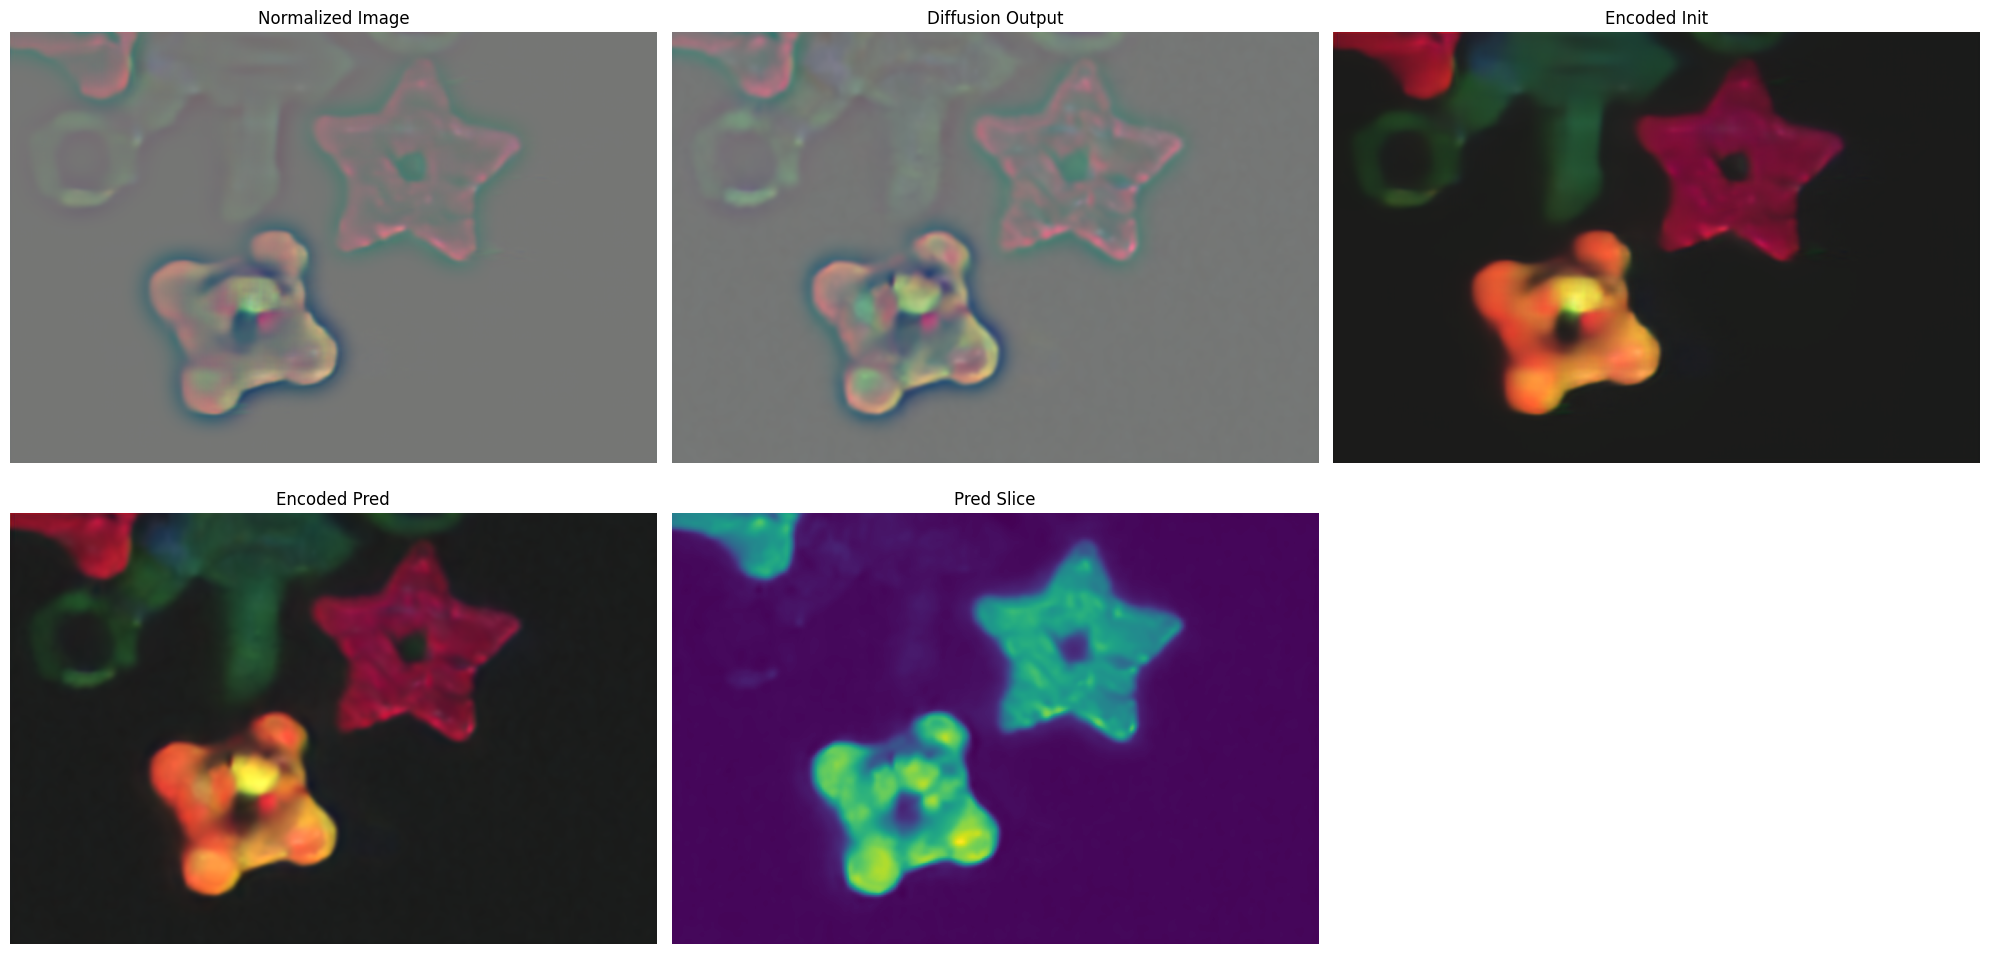

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03823115..1.0189779].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012527108..1.0794994].


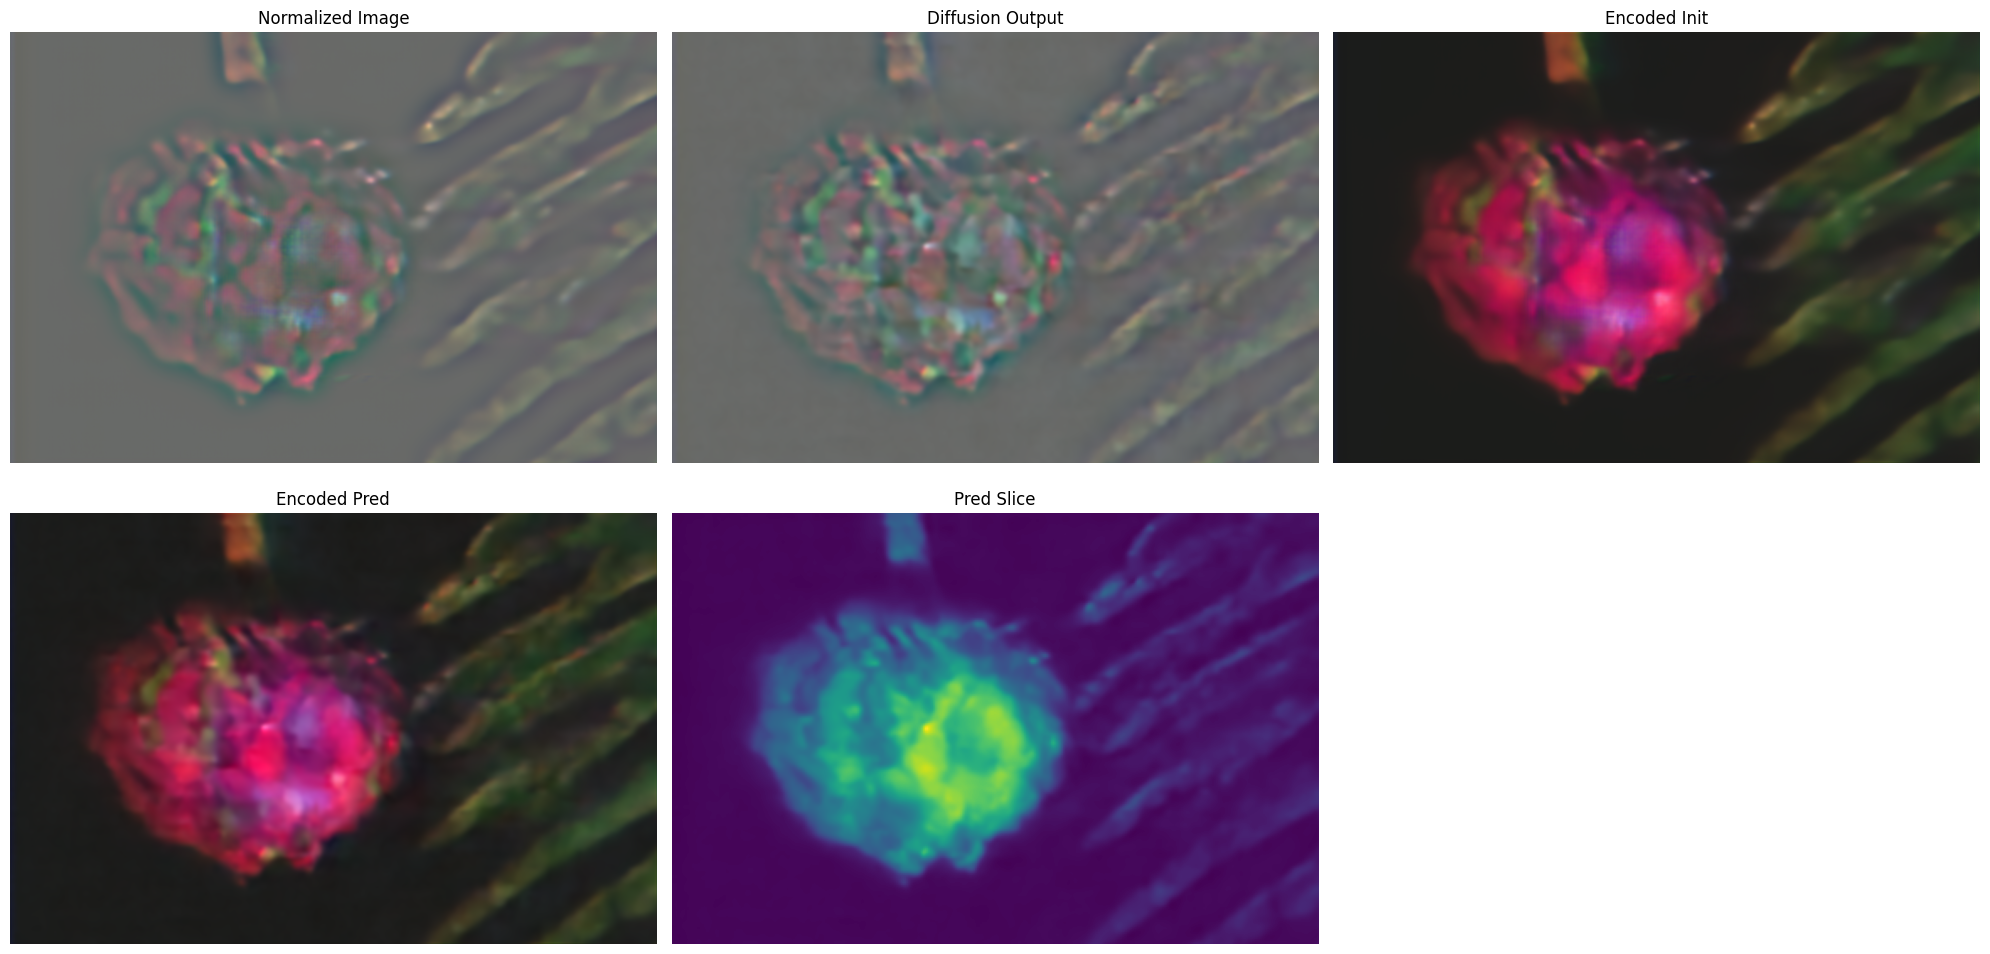

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061206006..1.0969458].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.086389534..1.1311985].


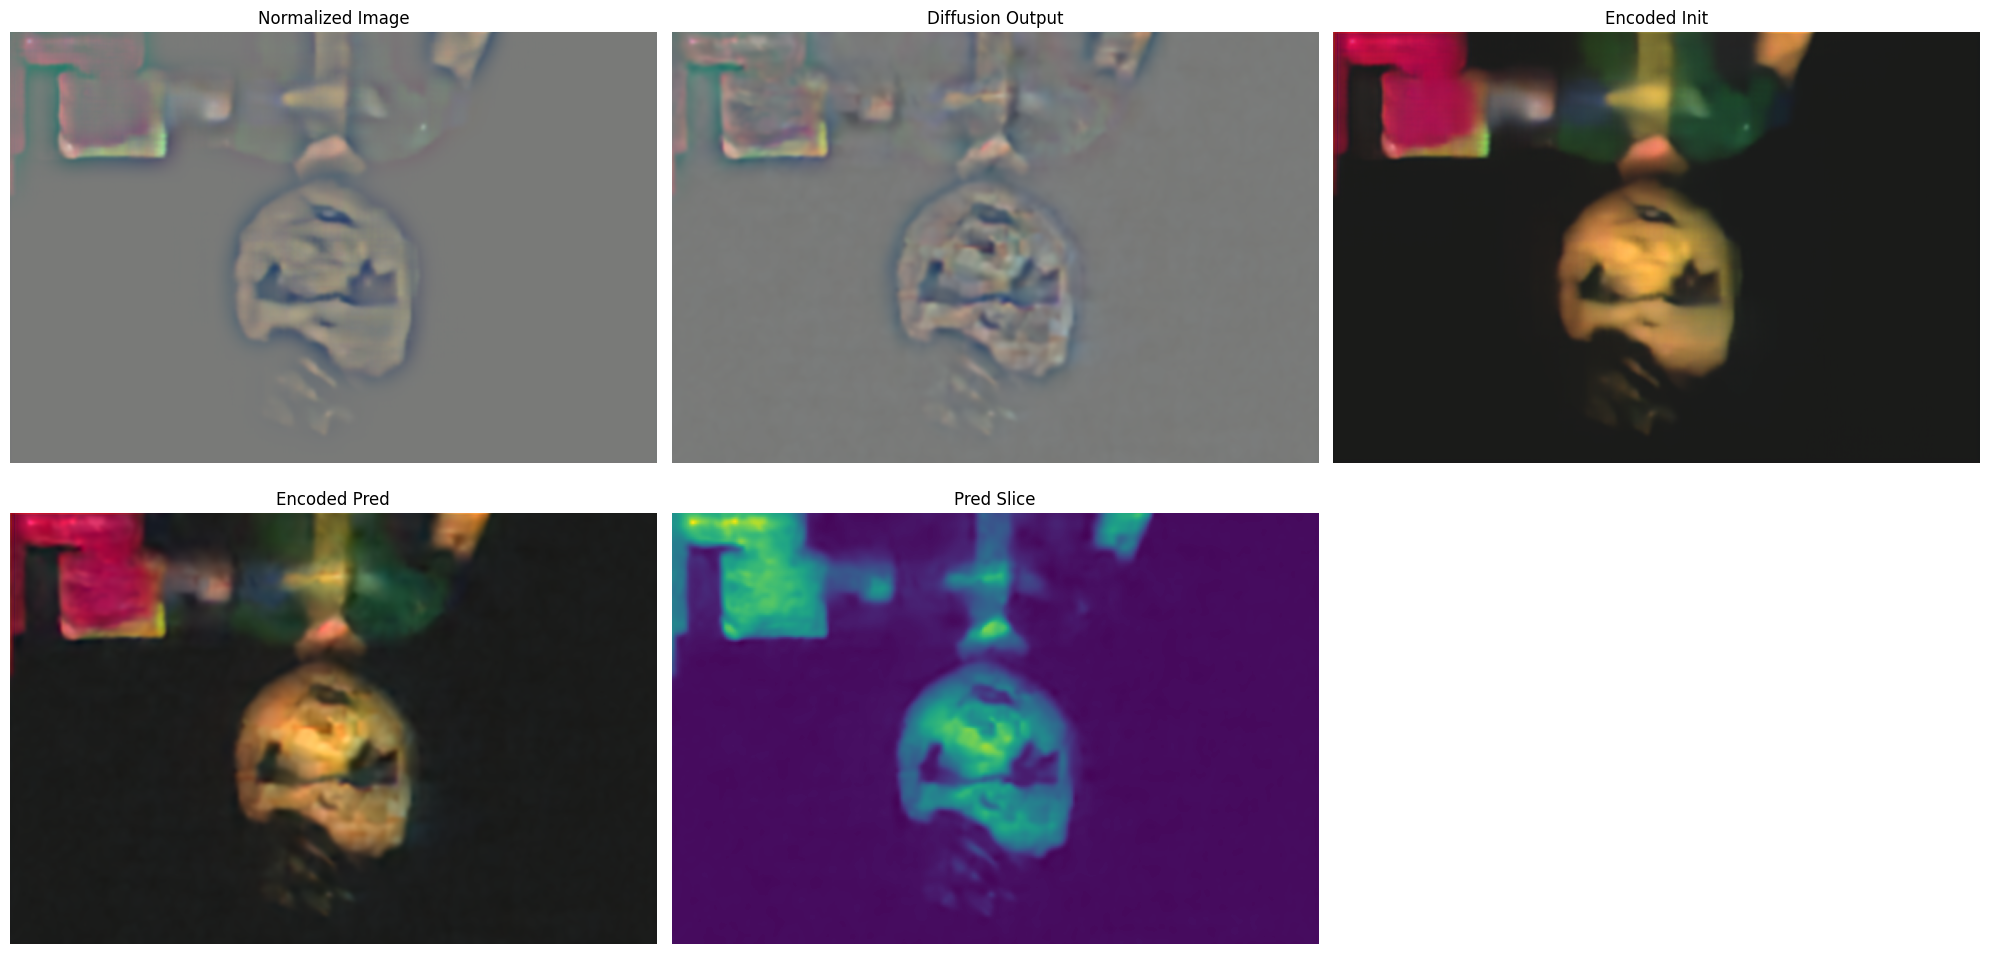

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.033171453..1.0740606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008092187..1.0105377].


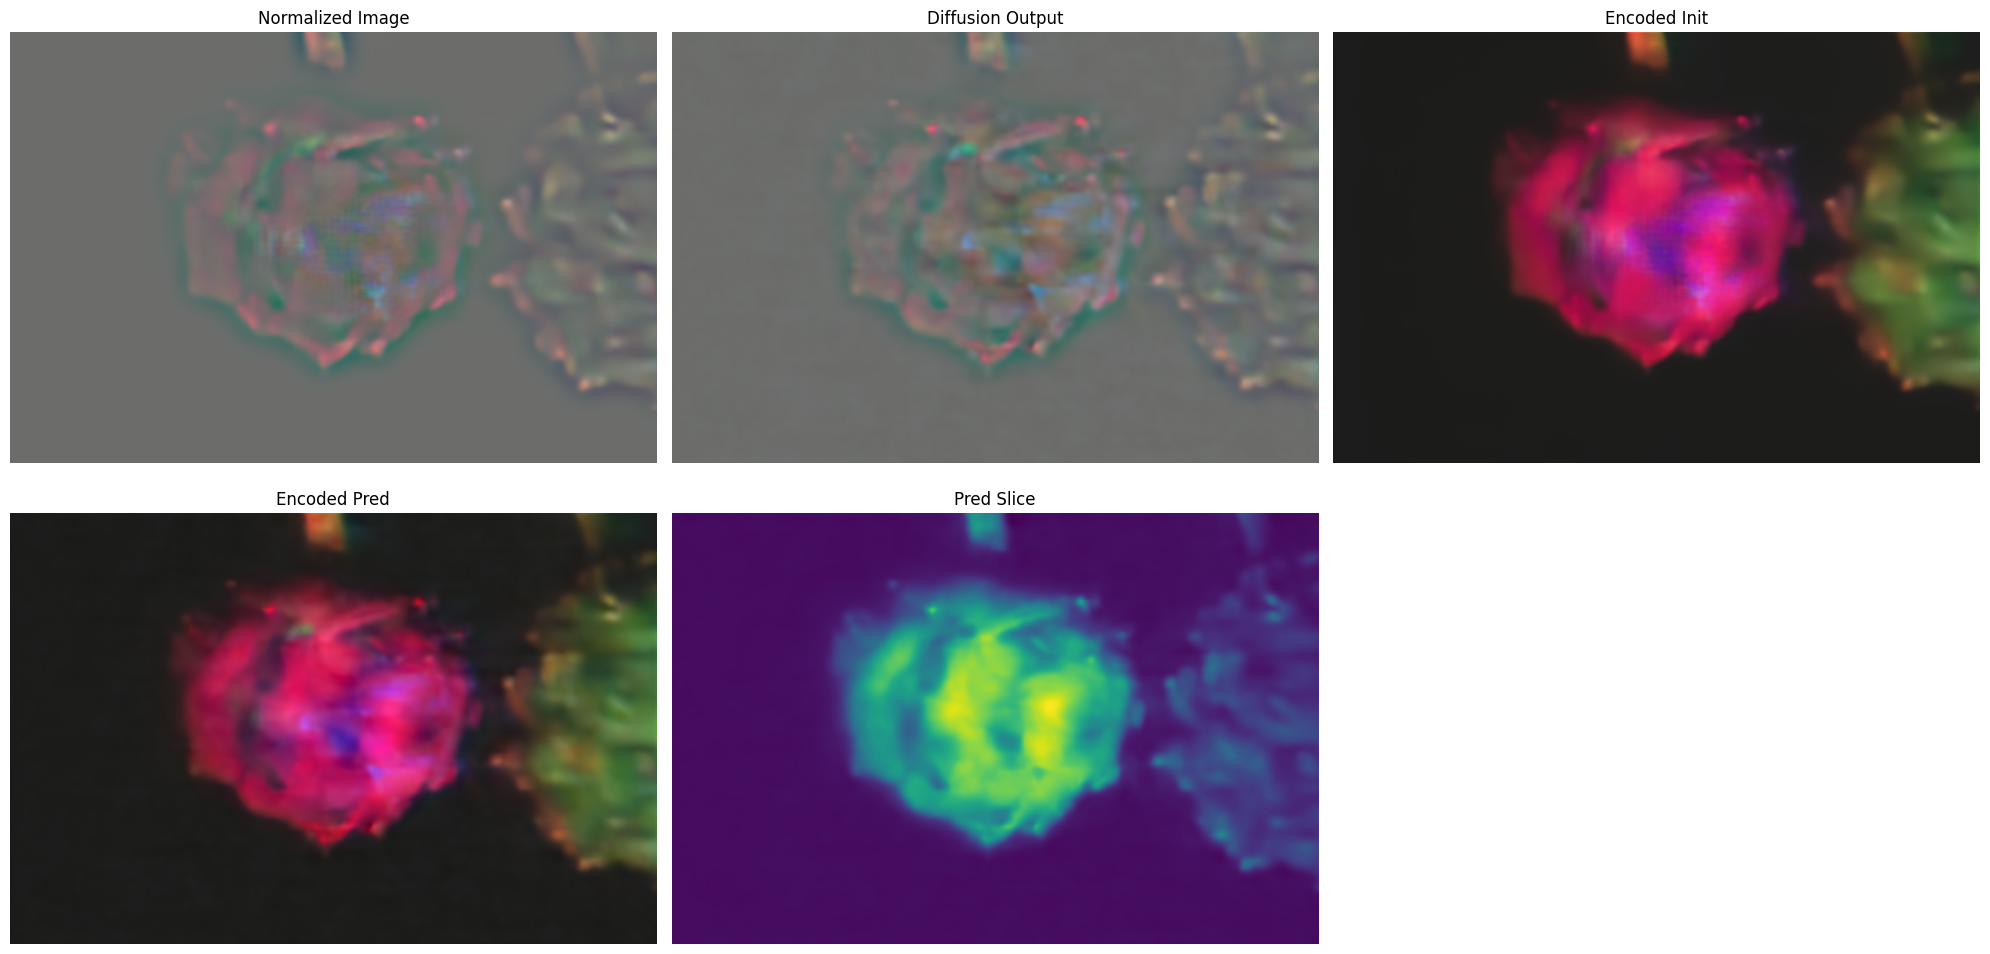

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0033240244..1.373467].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.115197174..1.5935296].


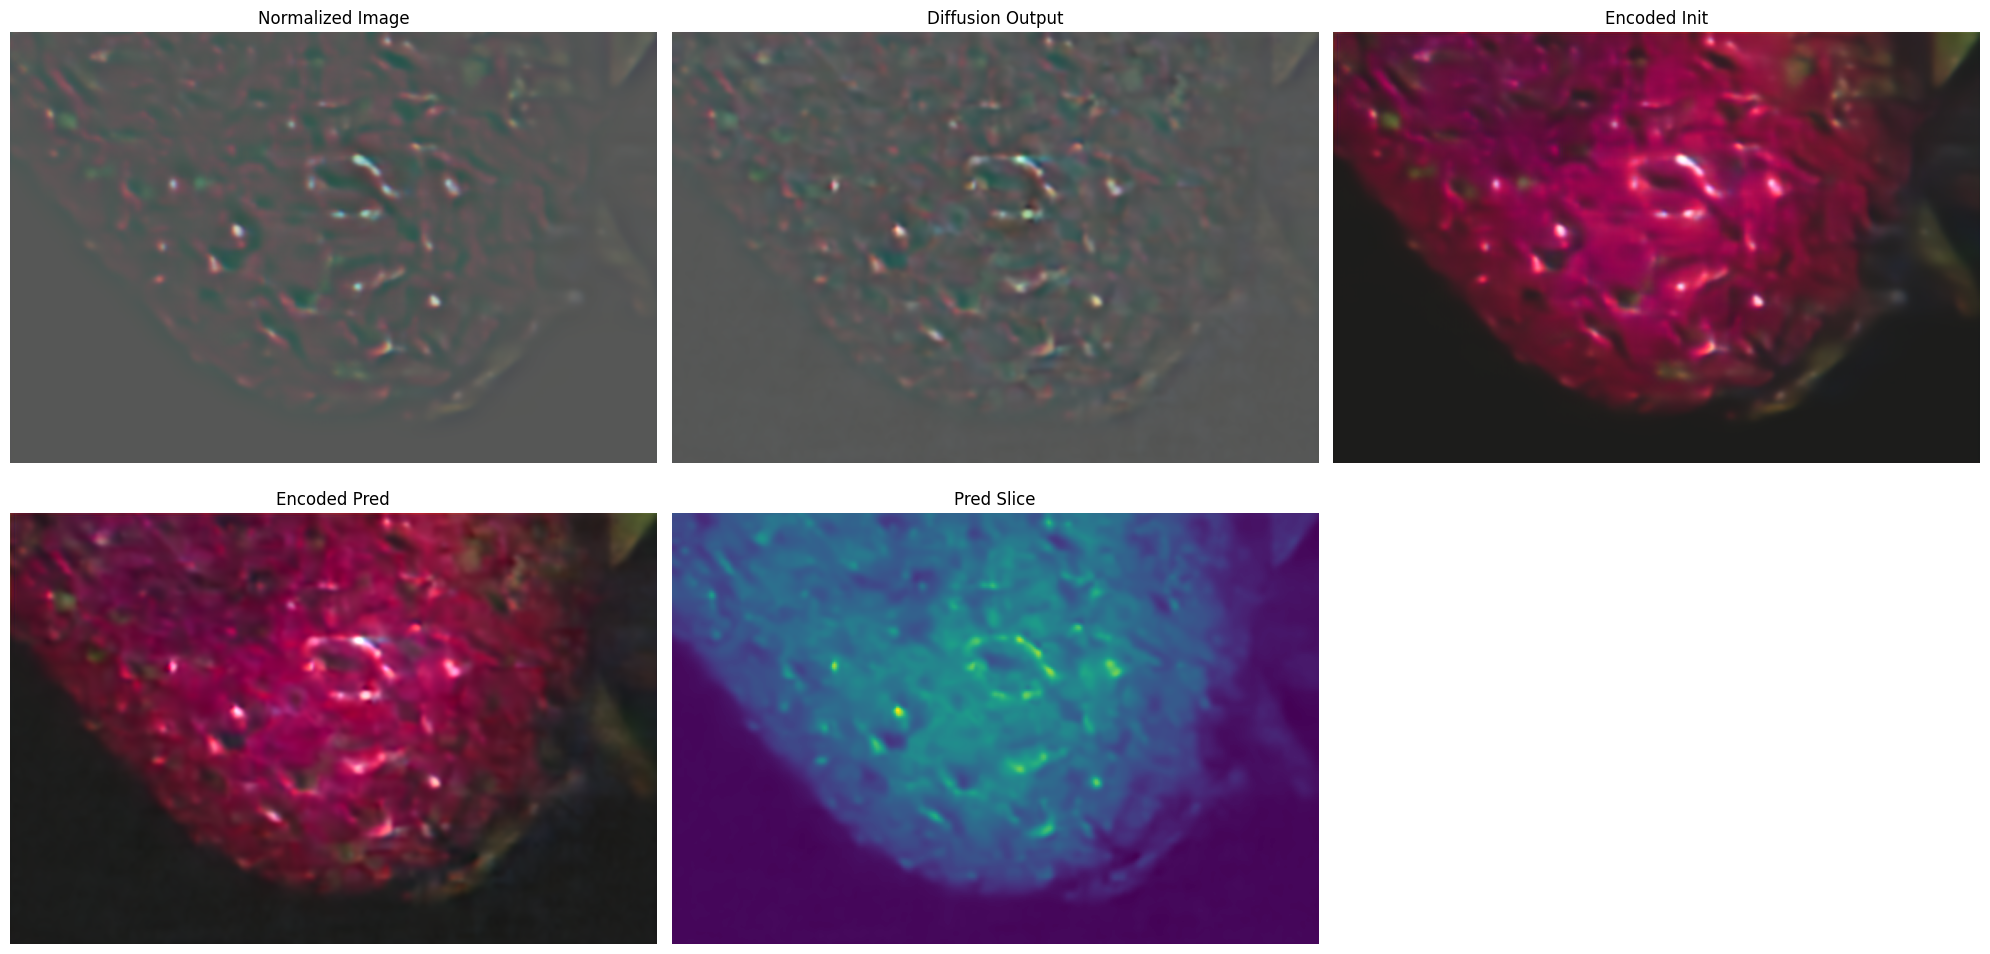

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import torch


@torch.no_grad()
def test():
    t_new = range(5)
    scenes = [sio.loadmat(f"./results/real/{i}.mat") for i in t_new]  # 加载.mat文件

    # 提取数据
    pred = torch.tensor([scenes[i]["pred"] for i in t_new])
    init = torch.tensor([scenes[i]["init"] for i in t_new])
    diffusion_outputs = torch.tensor([scenes[i]["diffusion_outputs"] for i in t_new])
    normalized_images = torch.tensor([scenes[i]["normalized_images"] for i in t_new])
    for i in t_new:

        # 创建2+2+1布局的子图
        fig, axs = plt.subplots(2, 3, figsize=(20, 10))
        axs = axs.ravel()

        images = [
            normalized_images[i].permute(1, 2, 0).cpu().numpy(),
            diffusion_outputs[i].permute(1, 2, 0).cpu().numpy(),
            SeVAE_model.encoder(init.cuda())[i].permute(1, 2, 0).cpu().numpy() + 0.1,
            SeVAE_model.encoder(pred.cuda())[i].permute(1, 2, 0).cpu().numpy() + 0.1,
            pred[i, 27].cpu().numpy() + 0.1,
        ]

        # 依次显示图像
        titles = ["Normalized Image", "Diffusion Output", "Encoded Init", "Encoded Pred", "Pred Slice"]
        for i, (ax, img, title) in enumerate(zip(axs, images, titles)):
            ax.imshow(img)
            ax.axis("off")  # 隐藏坐标轴
            ax.set_title(title)

        # 移除多余的最后一个子图
        fig.delaxes(axs[-1])

        plt.tight_layout()
        plt.show()                                                                     

test()